# Diffusion and Oxidant Concentration

This plots the change in several different aerosol properties as a function of diffusion coefficient and oxidant concentration. The diffusion coefficient is increased by an order of magnitude for each model scenario. The number after D indicates the negative base 10 logarithm of the diffusion coefficient for that scenario. The oxidant concentration is indicated by the condition where ft corresponds to flow tube ($5.04 \times 10^{10}$ molecules cm$^{-3}$), cfstr corresponds to continuous flow stir reactor ($5.04 \times 10^{8}$ molecules cm$^{-3}$), and day corresponds to daytime conditions ($5 \times 10^{6}$ molecules cm$^{-3}$). To run this notebook, the data must first be processed from XML files by running diffusion_processing.py. See that file or Postprocessing.ipynb for more information about the processing of the data.

In [1]:
%%HTML 
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [1]:
# Import modules

import warnings
warnings.filterwarnings('ignore')
import os

import StackSim
import numpy as np
import pandas as pd
from matplotlib import ticker
from scipy import stats
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import natsort
from cycler import cycler

# Notebook constants

diameter = 2E-5 # cm




In [2]:
# Create platform independent subdirectory

subdir = os.path.join(os.path.curdir, "dif_summary")

diffusion = dict()

diffusion["overall"] = ["D10", "D11", "D12", "D13", "D14", "D15", "D16", "D17", "D18"]
diffusion["ft"] = ["D11", "D12", "D13", "D14", "D15", "D16", "D17", "D18"]
diffusion["cfstr"] = ["D13", "D14", "D15", "D16", "D17", "D18"]
diffusion["day"] = ["D15", "D16", "D17", "D18"]


condition = ["ft", "cfstr", "day"]

D_string_conv = {"D10" : 1E-10, "D11" : 1E-11, "D12" : 1E-12, "D13" : 1E-13,
                "D14" : 1E-14, "D15" : 1E-15, "D16" : 1E-16,
                "D17" : 1E-17, "D18" : 8.39E-19}

D_string_format = {"D10" : r"$10^{-10}$", "D11" : r"$10^{-11}$", "D12" : r"$10^{-12}$",
                   "D13" : r"$10^{-13}$", "D14" : r"$10^{-14}$", "D15" : r"$10^{-15}$",
                   "D16" : r"$10^{-16}$", "D17" : r"$10^{-17}$", 
                   "D18" : r"$8.4 \times 10^{-19}$"}

cond_string_conv = {"ft" : "Flow Tube", 
                    "cfstr" : "Stir Reactor",
                    "day" : "Daytime"}

cond_OH_conv = {"ft" : 5.04E10,
               "cfstr" : 5.04E8,
               "day" : 5E6}

# Generate dictionary of filename strings

files = dict()

for cond in condition:
    for coefficient in diffusion["overall"]:
        if coefficient in diffusion[cond]:
            filename = cond+"_"+coefficient+".xlsx"
        else:
            filename = cond+"_SC.xlsx"
        files[cond+"_"+coefficient] = filename


    

## Simulation data plots

After loading the data, a plot of the effective uptake coefficient as a function of diffusion coefficients is generated.

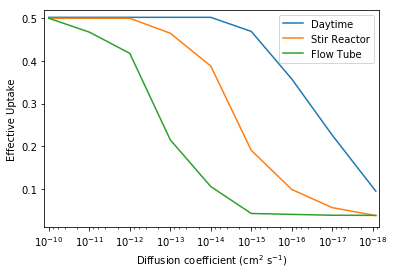

In [8]:
%matplotlib inline

diff_string = r'Diffusion coefficient (cm$^{2}$ s$^{-1}$)'
uptake_string = 'Effective Uptake'



uptake_data = dict()

fig, ax = plt.subplots(1)

for cond in reversed(condition):
    coef = np.array([])
    uptake = np.array([])
    
    # Get uptake coefficient from each file
    for D in diffusion["overall"]:
        with pd.ExcelFile(os.path.join(subdir, files[cond+"_"+D])) as xlsx:
            df = pd.read_excel(xlsx, 'model summary')
        coef = np.append(coef, D_string_conv[D])
        uptake = np.append(uptake, df[uptake_string].iloc[0])
    
    # Put in data frame
    uptake_data[cond] = pd.DataFrame({diff_string : coef, 
                                      cond_string_conv[cond] : uptake})
    
    # Plot data
    uptake_data[cond].plot(x = diff_string, y = cond_string_conv[cond],
                          ax = ax, logx=True, xlim=(1.3E-10, 7E-19),
                          ylim=(0, 0.51))

ax.set_xlim([1.3E-10, 7E-19])
ax.set_ylim([0.01, 0.52])
ax.set_xlabel(diff_string)
ax.set_ylabel(uptake_string)


fig.savefig(os.path.join(subdir, 'effuptake.png'),
            fmt='png', dpi=300, bbox_inches='tight')

    

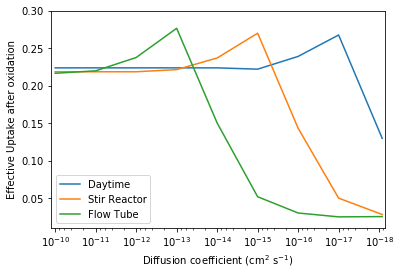

In [11]:
%matplotlib inline

diff_string = r'Diffusion coefficient (cm$^{2}$ s$^{-1}$)'
OC_string = 'O/C ratio'

cond_color = {'day' : 'tab:blue', 'cfstr' : 'tab:orange', 'ft' : 'tab:green'}

OC_data = dict()

fig, ax = plt.subplots(1)

for cond in reversed(condition):
    coef = np.array([])
    OC = np.array([])
    
    # Get uptake coefficient from each file
    for D in diffusion["overall"]:
        with pd.ExcelFile(os.path.join(subdir, files[cond+"_"+D])) as xlsx:
            df = pd.read_excel(xlsx, 'average data')
        coef = np.append(coef, D_string_conv[D])
        OC = np.append(OC, df[OC_string].iloc[-1])
    
    # Put in data frame
    OC_data[cond] = pd.DataFrame({diff_string : coef, 
                                      cond_string_conv[cond] : OC})
    
    # Plot data
    OC_data[cond].plot(x = diff_string, y = cond_string_conv[cond],
                          ax = ax, logx=True, xlim=(1.3E-10, 7E-19),
                          ylim=(0, 0.51), kind='line', color = cond_color[cond],
                           label = cond_string_conv[cond])

ax.set_xlim([1.3E-10, 7E-19])
ax.set_ylim([0.01, 0.3])
ax.set_xlabel(diff_string)
ax.set_ylabel(uptake_string+" after oxidation")


fig.savefig(os.path.join(subdir, 'OCratio_D.png'),
            fmt='png', dpi=300, bbox_inches='tight')

## Putting simulations on same scale

A pattern seems to emerge where the simulations show the same effective uptake, only offset by 100, just like their OH concentrations. We can remove this effect by calculating an analogue to the [Damk&ouml;hler number](https://en.wikipedia.org/wiki/Damk%C3%B6hler_numbers) from chemical engineering. This number uses the chemical reaction rate to the diffusion rate to generate a dimensionless number that describes the competition between reaction and diffusion. Here, we calculate it from the phenomenological rate constant for the reaction $k_{\text{rxn}}$ ($2 \times 10^{-12}$ cm$^3$ molecules$^{-1}$ s$^{-1}$ for instanteously mixed systems), the gas phase OH radical concentration [OH(g)], and the characteristic mixing time of an aerosol $\tau_{c}$.

$
\mathcal{Da} = k_{ \text{rxn} } \text{[OH(g)]} \tau_{c}
$

where $\tau_{c}$ is calculated as follows:

$
\tau_{c} = \frac{d_p^2}{4\pi^2 D}
$

where $d_p$ is the diameter of the particle in cm, $D$ is the diffusion coefficient in cm$^{2}$ s$^{-1}$. From these, we can calculate the Damk&ouml;hler number as follows:

$
\mathcal{Da} = \frac{k_{ \text{rxn} } \text{[OH(g)]}  d_p^2 }{4 \pi^2 D}
$

We can then use this to rescale our uptake results onto the same scale and regraph.

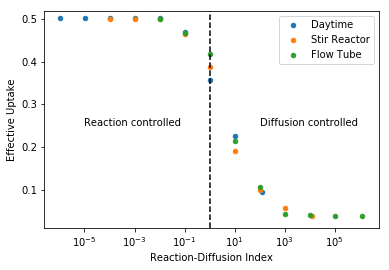

In [11]:
%matplotlib inline

# Function for calculating Damkueler numbers
        
def calc_Damkueler(D, conc):
    return 2E-12*conc*diameter**2/4/np.pi**2/D

fig, ax = plt.subplots(1)

cond_color = {'day' : 'tab:blue', 'cfstr' : 'tab:orange', 'ft' : 'tab:green'}


for cond in reversed(condition):
    uptake_data[cond]['Damkueler'] = calc_Damkueler(uptake_data[cond][diff_string],
                                                    cond_OH_conv[cond])
    
    uptake_data[cond].plot(x = 'Damkueler', y = cond_string_conv[cond],
                          kind = 'scatter', ax = ax, logx=True, 
                           color = cond_color[cond], label=cond_string_conv[cond])
    
ax.set_xlabel('Reaction-Diffusion Index')
ax.set_ylabel('Effective Uptake')
ax.set_ylim([0.01, 0.52])

ax.plot(np.array([1, 1]), np.array([0.01, 0.52]), '--k')
ax.text(1E2, 0.25, "Diffusion controlled")
ax.text(1E-5, 0.25, "Reaction controlled")
ax.legend(loc='best')


fig.savefig(os.path.join(subdir, 'effuptake_damkueler.png'),
            fmt='png', dpi=300, bbox_inches='tight')

For Damk&ouml;hler numbers greater than 1, the reaction is faster than diffusion, so the reaction is diffusion limited. For numbers less than 1, diffusion is faster than reaction, so the reaction occurs quickly. We can see that same behavior on the graph where a turning point in the uptake coefficient is reached at approximately $\mathcal{Da}$ = 1.

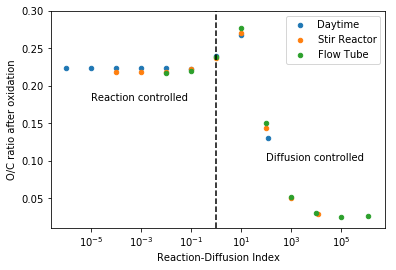

In [13]:
%matplotlib inline

fig, ax = plt.subplots(1)


for cond in reversed(condition):
    OC_data[cond]['Damkueler'] = calc_Damkueler(uptake_data[cond][diff_string],
                                                    cond_OH_conv[cond])
    
    OC_data[cond].plot(x = 'Damkueler', y = cond_string_conv[cond],
                          kind = 'scatter', ax = ax, logx=True, 
                           color = cond_color[cond], label=cond_string_conv[cond])
    
ax.set_xlabel('Reaction-Diffusion Index')
ax.set_ylabel('O/C ratio after oxidation')
ax.set_ylim([0.01, 0.3])

ax.plot(np.array([1, 1]), np.array([0.01, 0.3]), '--k')
ax.text(1E2, 0.1, "Diffusion controlled")
ax.text(1E-5, 0.18, "Reaction controlled")
ax.legend(loc='best')


fig.savefig(os.path.join(subdir, 'OCratio_damkueler.png'),
            fmt='png', dpi=300, bbox_inches='tight')

In [18]:
# Load data to be graphed below.

ScenarioData = dict()
OC_contours = dict()
Tri_contours = dict()
Peroxy_contours = dict()

for file in files.keys():
    with pd.ExcelFile(os.path.join(subdir, files[file])) as xlsx:
        ScenarioData[file] = pd.read_excel(xlsx, 'average data', header=0)
        Tri_contours[file] = pd.read_excel(xlsx, 'Triacontane (normalized)',
                                         skiprows=0, index_col=0, header=1)
        OC_contours[file] = pd.read_excel(xlsx, 'O to C ratio',
                                        skipows=0, index_col=0, header=1)
        Peroxy_contours[file] = pd.read_excel(xlsx, 'Peroxy radicals',
                                            skiprows=0, index_col=0, header=1)
        

        
    

## Model scenario comparison

To summarize this large data set, several average values are placed in a panel plot comparing diffusion coefficient and oxidant concentration.

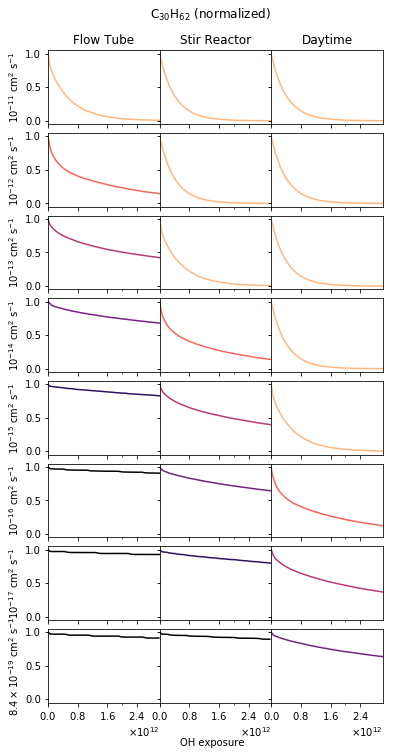

In [5]:
%matplotlib inline

# Create color map for plots

start = 0.85
stop = 0.0
num_lines = 6
cm_subsection = np.array([start, start, start, start])
cm_subsection = np.append(cm_subsection, np.linspace(start, stop, num_lines))
cm_subsection = np.append(cm_subsection, np.array([stop, stop, stop]))

colors = [ cm.magma(x) for x in cm_subsection ]

# Create dictionary for start of color index
color_idx = {"ft" : 4, "cfstr" : 2, "day" : 0}

# Triacontane decay comparison

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 12))


tri_string = "Triacontane (normalized)"

fig.suptitle(r"C$_{30}$H$_{62}$ (normalized)", y = 0.93)

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.figtext(0.43, 0.075, "OH exposure")



i = 0
for cond in condition:
    j = 0
    k = color_idx[cond]
    for D in diffusion["ft"]:
        ScenarioData[cond+"_"+D].plot(x = 'OH exposure', y = tri_string,
                                      ax = axes[j, i], legend=False, color = colors[k])
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].set_xlim([0, 3.01E12])
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
        k += 1
    i += 1
    
fig.savefig(os.path.join(subdir, 'triacontane_vert_colors.png'),
            fmt='png', dpi=600, bbox_inches='tight')

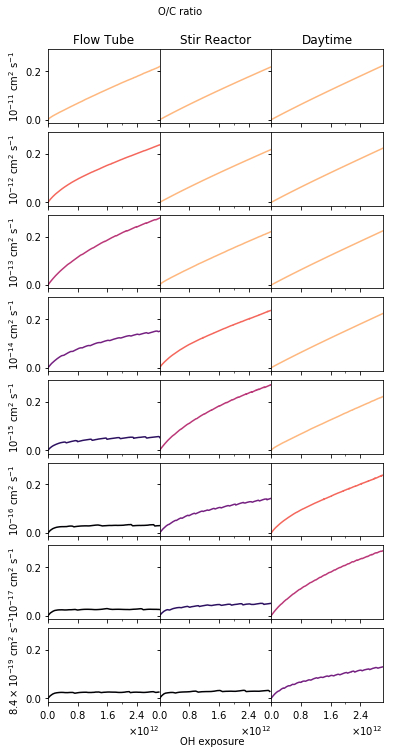

In [16]:
%matplotlib inline

# O/C ratio comparison

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 12))

OC_string = "O/C ratio"

plt.figtext(0.38, 0.92, OC_string)

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.figtext(0.43, 0.075, "OH exposure")

i = 0
for cond in condition:
    j = 0
    k = color_idx[cond]
    for D in diffusion["ft"]:
        ScenarioData[cond+"_"+D].plot(x = 'OH exposure', y = OC_string,
                                      ax = axes[j, i], legend=False, color = colors[k])
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].set_xlim([0, 3.01E12])
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
        k += 1
    i += 1
    
    
fig.savefig(os.path.join(subdir, 'O to C ratio horiz colors.png'),
            fmt='png', dpi=600, bbox_inches='tight')

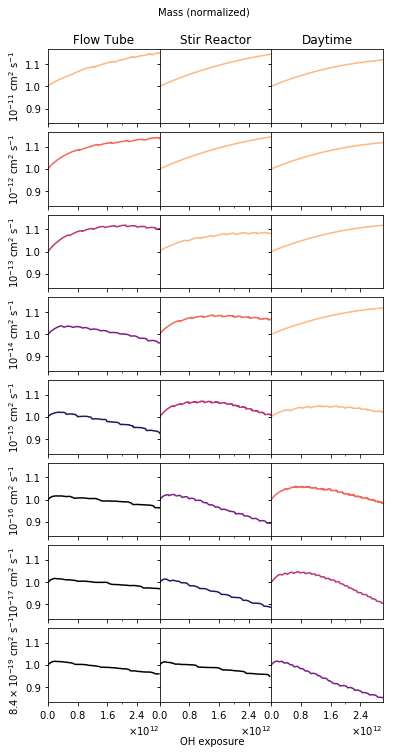

In [17]:
%matplotlib inline

# Mass comparison

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 12))

mass_string = "Mass (normalized)"

plt.figtext(0.38, 0.92, mass_string)

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.figtext(0.43, 0.075, "OH exposure")

i = 0
for cond in condition:
    j = 0
    k = color_idx[cond]
    for D in diffusion["ft"]:
        ScenarioData[cond+"_"+D].plot(x = 'OH exposure', y = mass_string,
                                      ax = axes[j, i], legend=False, color = colors[k])
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].set_xlim([0, 3.01E12])
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
        k += 1
    i += 1
    
fig.savefig(os.path.join(subdir, 'mass horiz colors.png'),
            fmt='png', dpi=600, bbox_inches='tight')

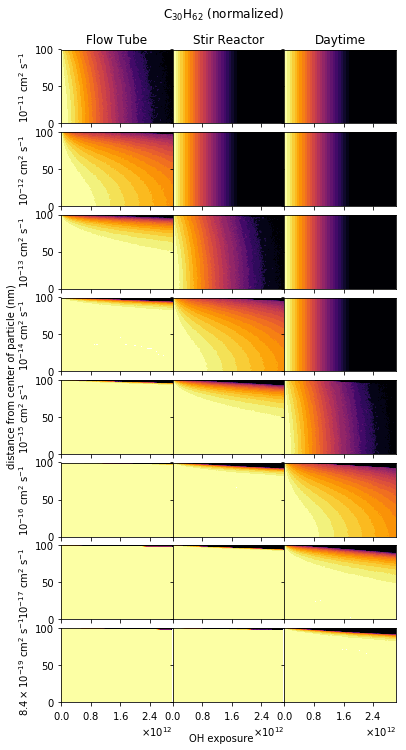

In [6]:
%matplotlib inline

# Set up color map levels

N_levels = 26
  
levels = np.array([0])
levels = np.append(levels, np.logspace(-4, 0, num=N_levels, base = np.e))
labels = np.logspace(-2, 0, num=6, base = 10)
    
cmap = mpl.cm.get_cmap('inferno', N_levels)
    
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 12))

fig.suptitle(r"C$_{30}$H$_{62}$ (normalized)", y = 0.93)

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.figtext(0.42, 0.08, "OH exposure")

plt.figtext(0.0, 0.6, "distance from center of particle (nm)", rotation='vertical')

i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        data = Tri_contours[cond+"_"+D]
        axes[j, i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))

        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
axes[0,0].set_xlim([0,3.02E12])
axes[0,0].xaxis.set_major_locator(ticker.MaxNLocator(4))

fig.savefig(os.path.join(subdir, 'tri_contours_vertical.png'),
            fmt='png', dpi=600, bbox_inches='tight')



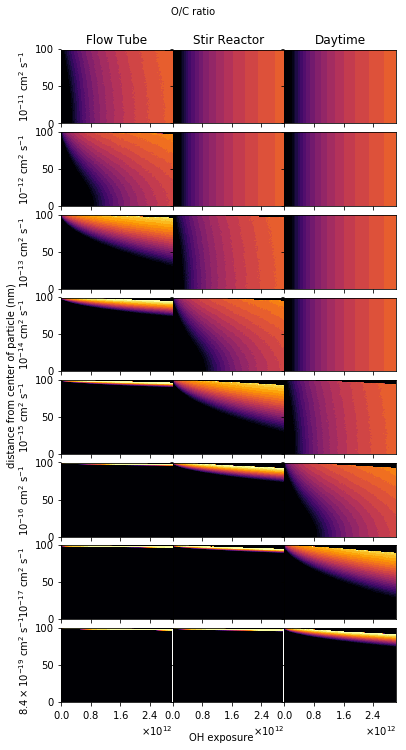

In [19]:
%matplotlib inline

# Set up color map levels

N_levels = 26
  
levels = np.array([0])
levels = np.append(levels, np.logspace(-4, 0, num=N_levels, base = np.e))
labels = np.logspace(-2, 0, num=6, base = 10)
    
cmap = mpl.cm.get_cmap('inferno', N_levels)
    
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 12))

plt.figtext(0.38, 0.92, "O/C ratio")

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.figtext(0.42, 0.08, "OH exposure")

plt.figtext(0.0, 0.6, "distance from center of particle (nm)", rotation='vertical')

i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        data = OC_contours[cond+"_"+D]
        axes[j, i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))

        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
axes[0,0].set_xlim([0,3.02E12])
axes[0,0].xaxis.set_major_locator(ticker.MaxNLocator(4))

fig.savefig(os.path.join(subdir, 'ocratio_contours vert.png'),
            fmt='png', dpi=300, bbox_inches='tight')

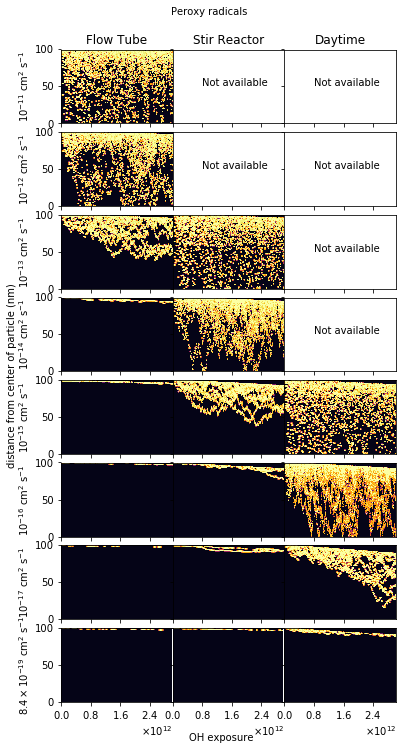

In [20]:
%matplotlib inline

# Set up color map levels

N_levels = 26
  
levels = np.linspace(0, 1, num=26)
labels = np.linspace(0, 1, num=6)
    
fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 12))

plt.figtext(0.38, 0.92, "Peroxy radicals")

plt.subplots_adjust(wspace=0, hspace=0.12)
plt.figtext(0.42, 0.08, "OH exposure")

plt.figtext(0.0, 0.6, "distance from center of particle (nm)", rotation='vertical')

i = 0
for cond in condition:
    j = 0
    axes[j, i].set_title(cond_string_conv[cond])
    for D in diffusion["ft"]:
        if j in [0, 1] and i in [1, 2]:
            axes[j, i].text(0.8E12, 50, "Not available")
            j += 1
            continue
        if j in [2, 3] and i == 2:
            axes[j, i].text(0.8E12, 50, "Not available")
            j += 1
            continue
            
        data = Peroxy_contours[cond+"_"+D]
        axes[j, i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))

        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
axes[0,0].set_xlim([0,3.02E12])
axes[0,0].xaxis.set_major_locator(ticker.MaxNLocator(4))

fig.savefig(os.path.join(subdir, 'peroxy_contours vert.png'),
            fmt='png', dpi=300, bbox_inches='tight')

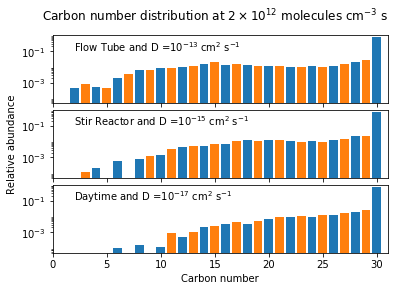

In [21]:
%matplotlib inline

# Plots of carbon number distributions for three related simulations

cond_comp = ["ft_D13", "cfstr_D15", "day_D17"]

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

fig.suptitle(r"Carbon number distribution at $2 \times 10^{12}$ molecules cm$^{-3}$ s")

axes[0].set_xlim([0, 31])
axes[-1].set_xlabel("Carbon number")
axes[1].set_ylabel("Relative abundance")
axes[1].set_ylim([5E-5, 0.99])

C_no_even = np.arange(2, 31, 2)
C_no_odd = np.arange(3, 31, 2)

# Time for comparison (in OH exposure units)
time = 2E12


i = 0
for cond in cond_comp:
    # Create simulation reference
    data = ScenarioData[cond]
    
    # Find index of time array closest to time
    index = (np.abs(data["OH exposure"] - time).argmin())
    
    # Find normalization factor
    norm = data["nC30"].iloc[0]
    
    # Get carbon number abundance for even carbon numbers
    C_no_abundance_even = np.array([data["nC"+str(no)].iloc[index] for no in C_no_even])/norm
    
    # Get carbon number abundance for odd carbon numbers
    C_no_abundance_odd = np.array([data["nC"+str(no)].iloc[index] for no in C_no_odd])/norm
    
    axes[i].bar(C_no_even, C_no_abundance_even, log=True, color='C0')
    axes[i].bar(C_no_odd, C_no_abundance_odd, log=True, color='C1')
    label = cond_string_conv[cond.split("_")[0]]+ r" and D =" + \
                D_string_format[cond.split("_")[1]] + r" cm$^2$ s$^{-1}$"
    axes[i].text(2, 1E-1, label)
    
    i += 1

fig.savefig(os.path.join(subdir, 'carbon no dist.png'),
            fmt='png', dpi=300, bbox_inches='tight')

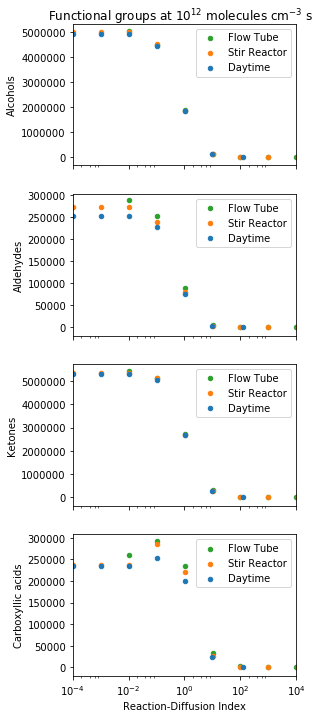

In [19]:


diff_string = r'Diffusion coefficient (cm$^{2}$ s$^{-1}$)'

func_data = dict()

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(4, 12))

fig.suptitle(r"Functional groups at $10^{12}$ molecules cm$^{-3}$ s", y = 0.9)

func_group = ["Alcohols", "Aldehydes", "Ketones", "Carboxyllic acids"]

time = 1E12

for cond in condition:
    coef = np.array([])
    func_data[cond] = pd.DataFrame()
    
    # Get uptake coefficient from each file
    for D in diffusion["overall"]:
        with pd.ExcelFile(os.path.join(subdir, files[cond+"_"+D])) as xlsx:
            df = pd.read_excel(xlsx, 'model summary')
            df2 = pd.read_excel(xlsx, 'average data')
        coef = np.append(coef, D_string_conv[D])
        
        
        # Find index of time array closest to time
        index = (np.abs(df2["OH exposure"] - time).argmin())
        
        func_data[cond] = func_data[cond].append(df2.loc[index, func_group])
            
    
    # Put diffusion coefficient in data frame
    func_data[cond][diff_string] = coef
    func_data[cond]['Damkueler'] = calc_Damkueler(func_data[cond][diff_string],
                                                    cond_OH_conv[cond])
    
    # Plot data
    i = 0
    
    for func in func_group:
        fplot = func_data[cond].plot(x = 'Damkueler', y = func,
                          ax = ax[i], logx=True, xlim=(1E-4, 1E4),
                          kind = 'scatter', color = cond_color[cond])
        fplot.set_label(cond)
        ax[i].set_ylabel(func)
        
        i += 1

for i in range(0, 4, 1):
    ax[i].legend(cond_string_conv.values())
        
#ax[0].set_xlim([1.3E-10, 7E-19])
#ax.set_ylim([0, 0.52])
ax[-1].set_xlabel("Reaction-Diffusion Index")


plt.show()
fig.savefig(os.path.join(subdir, 'funcgroup.png'),
            fmt='png', dpi=300, bbox_inches='tight')

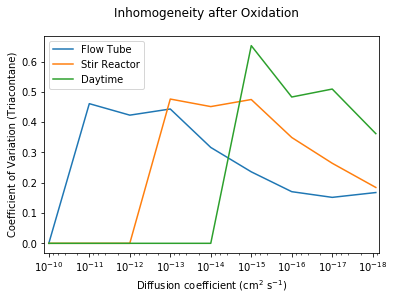

In [24]:
# Inhomogeneity of mixture as a function of OH and Diffusion coefficient
# Plots Coefficient of Variation based on Triacontane decay and O/C ratio for each condition
# at end of the equivalent of one week of oxidation

cov_data = dict()

fig, ax = plt.subplots(1)

time = 2E12

fig.suptitle(r"Inhomogeneity after Oxidation")

data_string = "Triacontane (normalized) COV"

for cond in condition:
    coef = np.array([])
    cov = np.array([])
    cov_data[cond] = pd.DataFrame()
    
    # Get COV from each file
    for D in diffusion["overall"]:
            with pd.ExcelFile(os.path.join(subdir, files[cond+"_"+D])) as xlsx:
                df = pd.read_excel(xlsx, 'model summary')
                df2 = pd.read_excel(xlsx, 'average data')
            coef = np.append(coef, D_string_conv[D])
        
            #index = (np.abs(df2["OH exposure"] - time).argmin())
            
            cov = np.append(cov, df2[data_string].iloc[-1])
    
    # Put diffusion coefficient in data frame
    cov_data[cond][diff_string] = coef
    cov_data[cond][data_string] = cov
    
    
    cov_data[cond].plot(x = coef, y = data_string, ax = ax, 
                   logx=True, xlim=(1.3E-10, 7E-19), kind = 'line')

ax.legend(cond_string_conv.values())
ax.set_xlabel(diff_string)
ax.set_ylabel("Coefficient of Variation (Triacontane)")

fig.savefig(os.path.join(subdir, 'tri_cov.png'),
            fmt='png', dpi=300, bbox_inches='tight')

plt.show()

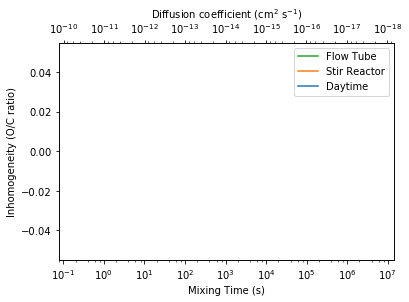

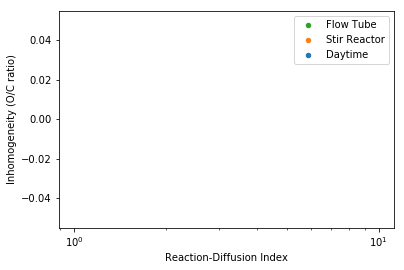

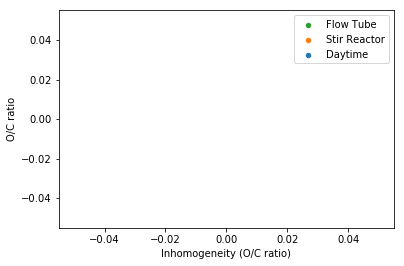

In [20]:
cov_data = dict()

fig, ax = plt.subplots(1)

mirrorax = ax.twiny()
time = 2E12

#fig.suptitle(r"Inhomogeneity at end of oxidation")

data_string = "O/C ratio COV"

for cond in condition:
    coef = np.array([])
    
    cov = np.array([])
    cov_data[cond] = pd.DataFrame()
    
    # Get COV from each file
    for D in diffusion["overall"]:
            with pd.ExcelFile(os.path.join(subdir, files[cond+"_"+D])) as xlsx:
                df = pd.read_excel(xlsx, 'model summary')
                df2 = pd.read_excel(xlsx, 'average data')
                       
            coef = np.append(coef, D_string_conv[D])
        
            #index = (np.abs(df2["OH exposure"] - time).argmin())
            index = len(df2.index)-1
            
            cov_data[cond] = cov_data[cond].append(df2.ix[index, [data_string, "O/C ratio"]])
    
    # Put diffusion coefficient, characteristic mixing time, and cov in data frame
    cov_data[cond][diff_string] = coef
    cov_data[cond]["Mixing Time (s)"] = 2E-5**2/coef/np.pi**2/4
    cov_data[cond]['Damkueler'] = calc_Damkueler(cov_data[cond][diff_string],
                                                    cond_OH_conv[cond])
    #cov_data[cond][data_string] = cov
    
    cov_data[cond].plot(x = "Mixing Time (s)", y = data_string, ax = ax, 
                       logx=True, kind = 'line', xlim=(0.078, 1.4E7), color = cond_color[cond])

ax.legend(cond_string_conv.values())
ax.set_xlabel("Mixing Time (s)")
ax.set_ylabel("Inhomogeneity (O/C ratio)")

mirrorax.set_xlim([1.3E-10, 7E-19])
mirrorax.set_xlabel(diff_string)
mirrorax.set_xscale('log')

fig.savefig(os.path.join(subdir, 'ocratio_cov.png'),
            fmt='png', dpi=300, bbox_inches='tight')

plt.show()

fig, ax = plt.subplots(1)

for cond in condition:
    cov_data[cond].plot(x = "Damkueler", y = data_string, ax = ax,
                       logx = True, kind = 'scatter',
                       color = cond_color[cond], label=cond_string_conv[cond])
    
ax.set_xlabel('Reaction-Diffusion Index')
ax.set_ylabel('Inhomogeneity (O/C ratio)')

fig.savefig(os.path.join(subdir, 'ocratio_cov_damkueler.png'),
           fmt = 'png', dpi=300, bbox_inches='tight')

plt.show()

fig, ax = plt.subplots(1)

for cond in condition:
    cov_data[cond].plot(x = data_string, y = "O/C ratio", ax = ax, kind = 'scatter',
                       color = cond_color[cond], label=cond_string_conv[cond])

ax.set_xlabel("Inhomogeneity (O/C ratio)")
fig.savefig(os.path.join(subdir, "ocratio_inhomogen.png"),
           fmt='png', dpi=300, bbox_inches='tight')    
plt.show()